# Trader Performance vs Market Sentiment
1. Datasets preprocessing
2. Merging datasets into final dataset
3. Compare performance across sentiment regimes
4. behavioral analysis
5. Segment traders by activity and consistency
6. Build a simple predictive model

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Classification of sentiment and convertion of datetime


In [96]:
# fear greed dataset
sentiment = pd.read_csv("fear_greed_index.csv")
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment = sentiment[['date', 'value', 'classification']]
sentiment['sentiment'] = sentiment['classification'].replace({'Extreme Fear': 'Fear','Extreme Greed': 'Greed'},inplace=True)
sentiment.shape                         #   (2644, 4)
sentiment.isnull().sum()                #   no nulls
sentiment.duplicated().sum()            #   no duplicates
sentiment['classification'].value_counts()

C:\Users\guggi\AppData\Local\Temp\ipykernel_13272\2263410250.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sentiment['sentiment'] = sentiment['classification'].replace({'Extreme Fear': 'Fear','Extreme Greed': 'Greed'},inplace=True)


classification
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64

# preprocessing traders data

In [98]:
# historical dataset
trader = pd.read_csv("historical_data.csv")
trader['Timestamp IST'] = pd.to_datetime(trader['Timestamp IST'], dayfirst = True)
trader['date'] = trader['Timestamp IST'].dt.date
trader['date'] = pd.to_datetime(trader['date'])
trader = trader[['Account','date','Size USD','Side','Closed PnL', 'Fee']]
trader.shape                      #     (211224, 6)
trader.isnull().sum()             #     no nulls
trader.duplicated().sum()         #     24963
trader.drop_duplicates(inplace=True)
trader.shape                      #     ((186261, 6)

(186261, 6)

# checking the trader range within the sentiment range 

In [7]:

print(trader['date'].min(),"to",trader['date'].max())
print(sentiment['date'].min(),"to",sentiment['date'].max())

2023-05-01 00:00:00 to 2025-05-01 00:00:00
2018-02-01 00:00:00 to 2025-05-02 00:00:00


In [100]:
long_trades = (
    trader[trader['Side'].str.lower() == 'buy']
    .groupby(['Account', 'date'])
    .size()
    .reset_index(name='long_trades')
)


# creating daily metrics
Trades were aggregated to trader-day level to align with daily sentiment data.
Daily trader metrics were merged with sentiment data using date as key.



In [102]:

daily_metrics = trader.groupby(['Account','date']).agg(
    daily_PnL = ('Closed PnL','sum'),
    trade_count = ('Closed PnL','count'),
    avg_position_size = ('Size USD','mean'),
    total_size = ('Size USD','sum'),
    total_fees=('Fee', 'sum')
).reset_index()
daily_metrics = daily_metrics.merge(
    long_trades,
    on=['Account', 'date'],
    how='left'
)
daily_metrics['long_trades'] = daily_metrics['long_trades'].fillna(0)
daily_metrics['long_ratio'] = (daily_metrics['long_trades'] /daily_metrics['trade_count'])

daily_metrics.shape           #     (2341, 7)
daily_metrics.head()

,Account,date,daily_PnL,trade_count,avg_position_size,total_size,total_fees,long_trades,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.00000,138,5618.889493,775406.75,155.248728,0.0,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.00000,49,7465.433469,365806.24,50.222921,0.0,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.00000,38,24841.576842,943979.92,94.397977,0.0,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.00000,12,28186.666667,338240.00,33.823995,12.0,1.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1467.47774,24,18484.447083,443626.73,97.503923,10.0,0.416667


In [104]:
# caluculating win rate
trade_counts = trader.groupby(['Account', 'date']).size().reset_index()
trade_counts.columns = ['Account', 'date', 'total_trades']
winning_trades = (
    trader[trader['Closed PnL'] > 0]      
    .groupby(['Account', 'date'])         
    .size()                               
    .reset_index(name='winning_trades')
)
win_rate_df = trade_counts.merge(winning_trades,on=['Account', 'date'],how='left')
win_rate_df['winning_trades'] = win_rate_df['winning_trades'].fillna(0)


win_rate_df['win_rate'] = win_rate_df['winning_trades'] / win_rate_df['total_trades']

In [106]:
# merging to daily metrics
win_rate_df = win_rate_df[['Account','date','win_rate']]
daily_metrics = daily_metrics.drop(columns=['win_rate'], errors='ignore')
daily_metrics = daily_metrics.merge(win_rate_df,on=['Account','date'],how = 'left')
daily_metrics.shape

(2341, 10)

In [108]:
# final dataset
final_df = daily_metrics.merge(sentiment[['date', 'classification', 'value']],on='date',how='inner')
final_df.shape                                       #      (2341, 10)
final_df['classification'].isnull().sum()            #      0
final_df = final_df[final_df['classification'] != 'Neutral']
final_df.head()

,Account,date,daily_PnL,trade_count,avg_position_size,total_size,total_fees,long_trades,long_ratio,win_rate,classification,value
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.00000,138,5618.889493,775406.75,155.248728,0.0,0.000000,0.000000,Greed,76
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.00000,49,7465.433469,365806.24,50.222921,0.0,0.000000,0.000000,Greed,90
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.00000,38,24841.576842,943979.92,94.397977,0.0,0.000000,0.000000,Greed,83
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.00000,12,28186.666667,338240.00,33.823995,12.0,1.000000,0.000000,Greed,94
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1467.47774,24,18484.447083,443626.73,97.503923,10.0,0.416667,0.416667,Greed,79


In [110]:
# performance
performance_summary = final_df.groupby('classification').agg(
    avg_daily_pnl=('daily_PnL', 'mean'),
    median_daily_pnl=('daily_PnL', 'median'),
    pnl_std=('daily_PnL', 'std'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_count=('trade_count', 'mean')
).reset_index()
performance_summary.head()

,classification,avg_daily_pnl,median_daily_pnl,pnl_std,avg_win_rate,avg_trade_count
0,Fear,4819.674477,125.670461,28426.598151,0.356799,89.879747
1,Greed,3936.972253,260.631728,28272.717534,0.361510,70.080920


Key observations:
1. Average PnL higher during Fear, but median PnL higher during Greed.
2. Win rate slightly higher in Greed.


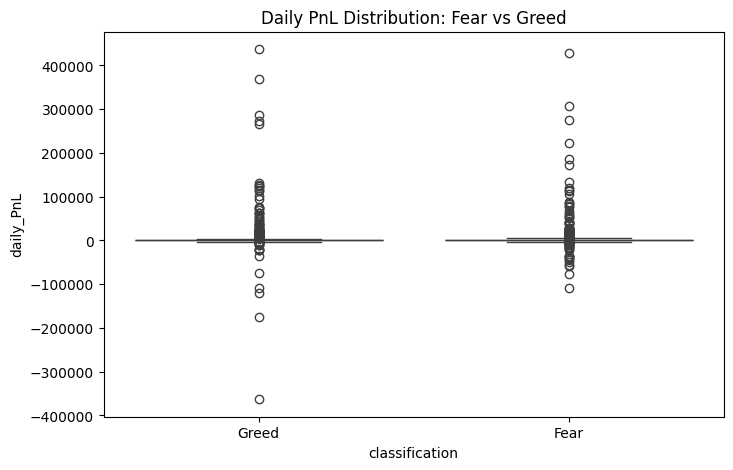

In [112]:
# data visualization
#PnL Distribution
plt.figure(figsize=(8,5))
sns.boxplot(data=final_df, x='classification', y='daily_PnL')
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()

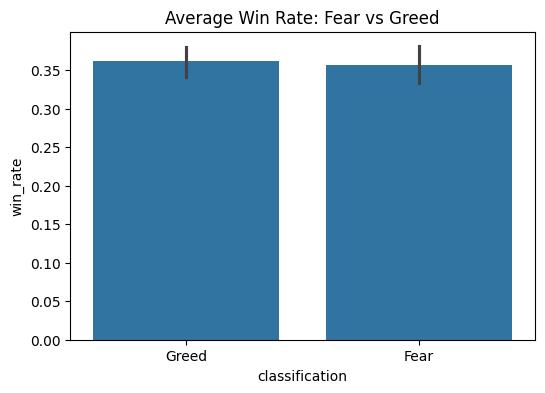

In [72]:
# win rate vs sentiment
plt.figure(figsize=(6,4))
sns.barplot(data=final_df, x='classification', y='win_rate')
plt.title("Average Win Rate: Fear vs Greed")
plt.show()

In [114]:
# behavioral
behavior_summary = final_df.groupby('classification').agg(
    avg_trade_count=('trade_count', 'mean'),
    avg_position_size=('avg_position_size', 'mean'),
    avg_long_ratio=('long_ratio', 'mean')
).reset_index()
behavior_summary.head()

,classification,avg_trade_count,avg_position_size,avg_long_ratio
0,Fear,89.879747,9357.596836,0.522241
1,Greed,70.080920,6168.432722,0.473705


In [118]:
# Frequent vs Infrequent Traders
trader_frequency = final_df.groupby('Account').agg(avg_trade_per_day=('trade_count', 'mean')).reset_index()
frequency_threshold = trader_frequency['avg_trade_per_day'].median()
trader_frequency['frequency_segment'] = trader_frequency['avg_trade_per_day'].apply(lambda x: 'high frequency' if x > frequency_threshold else 'low frequency')
final_df = final_df.merge(trader_frequency[['Account', 'frequency_segment']],on='Account',how='left')


In [122]:
segment_summary = final_df.groupby(
    ['frequency_segment', 'classification']
).agg(
    avg_daily_PnL=('daily_PnL', 'mean'),
    median_daily_PnL=('daily_PnL', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_count=('trade_count', 'mean')
).reset_index()

segment_summary

,frequency_segment,classification,avg_daily_PnL,median_daily_PnL,avg_win_rate,avg_trade_count
0,high frequency,Fear,6654.264435,230.103259,0.387068,139.686183
1,high frequency,Greed,4395.640836,553.525599,0.426946,118.724395
2,low frequency,Fear,2661.630642,0.000000,0.321194,31.292011
3,low frequency,Greed,3550.308157,0.199080,0.306346,29.073783


In [124]:
# consistant traders vs volatile traders
trader_volatility = final_df.groupby('Account').agg(PnL_std=('daily_PnL', 'std')).reset_index()
volatility_threshold = trader_volatility['PnL_std'].median()
trader_volatility['volatility_segment'] = trader_volatility['PnL_std'].apply(lambda x: 'Volatile' if x > volatility_threshold else 'Consistent')
final_df = final_df.merge(trader_volatility[['Account', 'volatility_segment']],on='Account',how='left')


In [126]:
vol_segment_summary = final_df.groupby(
    ['volatility_segment', 'classification']
).agg(
    avg_daily_PnL=('daily_PnL', 'mean'),
    median_daily_PnL=('daily_PnL', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_count=('trade_count', 'mean')
).reset_index()

vol_segment_summary

,volatility_segment,classification,avg_daily_PnL,median_daily_PnL,avg_win_rate,avg_trade_count
0,Consistent,Fear,239.067662,73.754403,0.361084,39.405941
1,Consistent,Greed,1773.344816,389.459698,0.392334,64.952564
2,Volatile,Fear,9613.884718,569.219880,0.352314,142.707254
3,Volatile,Greed,8220.295605,0.000000,0.300486,80.233503


## Strategy Recommendations

1. Increase activity for consistent traders during Greed regimes.
2. Volatile traders should reduce exposure during Greed periods.
3. Implement risk controls during Fear regimes.


In [144]:
#predicting next day 
final_df['next_day_PnL'] = final_df.groupby('Account')['daily_PnL'].shift(-1)
final_df['next_day_profitable'] = (final_df['next_day_PnL'] > 0).astype(int)
final_df = final_df.dropna(subset=['next_day_PnL'])
final_df['sentiment_encoded'] = (final_df['classification'].map({'Fear': 0, 'Greed': 1}))


C:\Users\guggi\AppData\Local\Temp\ipykernel_13272\2168969112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['next_day_PnL'] = final_df.groupby('Account')['daily_PnL'].shift(-1)
C:\Users\guggi\AppData\Local\Temp\ipykernel_13272\2168969112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['next_day_profitable'] = (final_df['next_day_PnL'] > 0).astype(int)
C:\Users\guggi\AppData\Local\Temp\ipykernel_13272\2168969112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [146]:
features = [
    'trade_count',
    'avg_position_size',
    'win_rate',
    'long_ratio',
    'sentiment_encoded'
]

X = final_df[features]
y = final_df['next_day_profitable']


In [148]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6394736842105263
              precision    recall  f1-score   support

           0       0.56      0.21      0.30       143
           1       0.65      0.90      0.76       237

    accuracy                           0.64       380
   macro avg       0.60      0.55      0.53       380
weighted avg       0.62      0.64      0.59       380



In [152]:
coef_df = pd.DataFrame({'Feature': features,'Coefficient': model.coef_[0]})

coef_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
2,win_rate,0.995746
3,long_ratio,0.532878
4,sentiment_encoded,0.197389
0,trade_count,0.002372
1,avg_position_size,-0.000002


# conclusion
1. Market sentiment influences trader behavior and performance. 
2. Risk-taking intensifies during Fear regimes, while Greed favors consistency. 
3. Segment-level analysis highlights the importance of trader type in regime sensitivity. 
4. These findings support adaptive, sentiment-aware trading strategies.
